In [1]:
import IPython
import IPython.display as ipd
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm

from lib.float2d_to_rgb_layer import Float2DToRGB
from lib.melspectrogram_layer import MelSpectrogram
from lib.power_to_db_layer import PowerToDb
from lib.utils import float2d_to_rgb
from src.config import c
from src.services import get_msg_provider, get_wave_provider

In [2]:
c['MSG_POWER'] = 1

In [3]:
N_MELS = 256
N_TIMESTEPS = 256
POWER = 3
N_WAVES = 64

In [4]:
wave_p = get_wave_provider(c)
msg_p = get_msg_provider(c)

waves = []

df = pd.read_pickle("/app/_work/dataset-C.pickle")
fragments = df[["filename", "_from_s", "_to_s"]].sample(n=N_WAVES).to_dict("list")

for f, s, e in tqdm(
    zip(fragments["filename"], fragments["_from_s"], fragments["_to_s"]),
    total=len(fragments["filename"])
):
    waves.append(wave_p.get_audio_fragment(f, [s, e]))

waves = np.array(waves)

100%|██████████| 64/64 [00:00<00:00, 654.00it/s]


In [5]:
waves = np.repeat(waves, 100, axis=0)
np.random.shuffle(waves)

In [6]:
ipd.Audio(data=waves[10], rate=c['AUDIO_SR'])

In [7]:
hop_length = waves[0].shape[0] // (N_TIMESTEPS - 1)

i = x = keras.layers.Input(shape=waves[0].shape, dtype=waves[0].dtype)

x = MelSpectrogram(
    sample_rate=c["AUDIO_SR"],
    fft_size=c["MSG_N_FFT"],
    n_mels=N_MELS,
    hop_length=hop_length,
    power=POWER,
)(x)

o_float = x = PowerToDb()(x)

o_rgb = x = Float2DToRGB()(x)

m = keras.models.Model(inputs=[i], outputs=[o_float, o_rgb])

In [8]:
print(f"{waves.size * waves.itemsize / 2**30:.2f} GB")

1.91 GB


In [9]:
for i in range(1):
    msgs_f, msgs_rgb = m.predict(waves, verbose=1, batch_size=64)

100/100 [==============================] - 5s 39ms/step


In [10]:
%timeit float2d_to_rgb(msg_p.msg(waves[0], N_MELS, N_TIMESTEPS, POWER))

4.1 ms ± 25.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


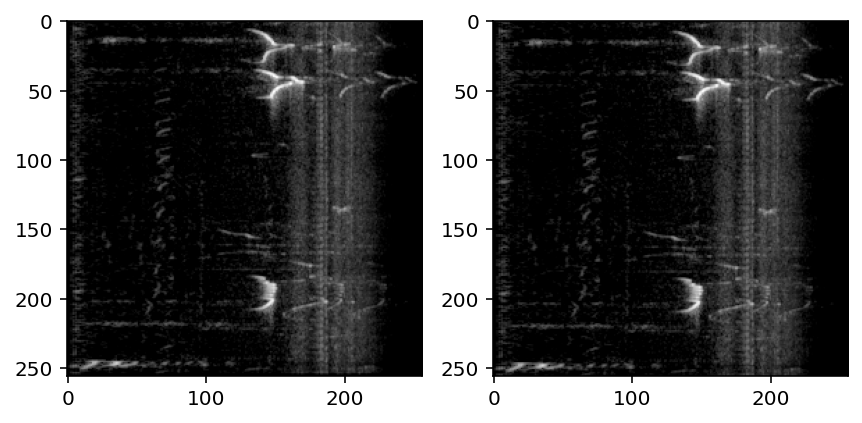

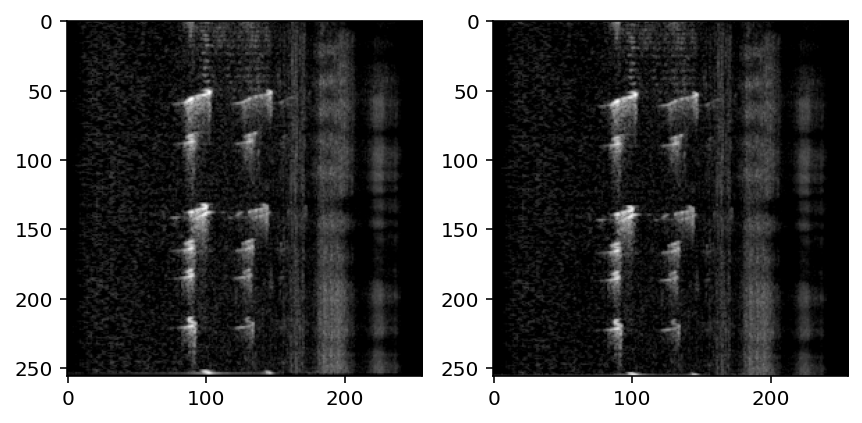

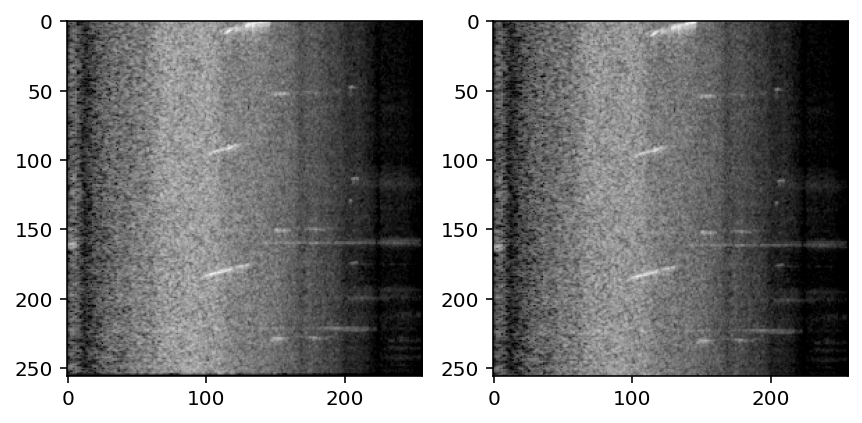

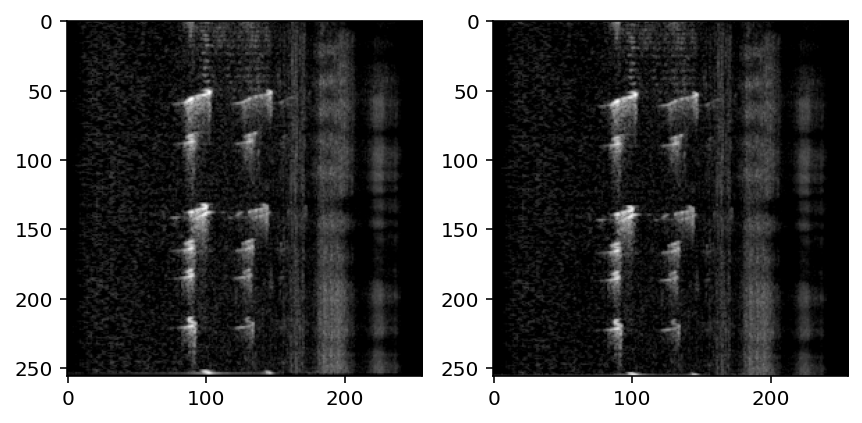

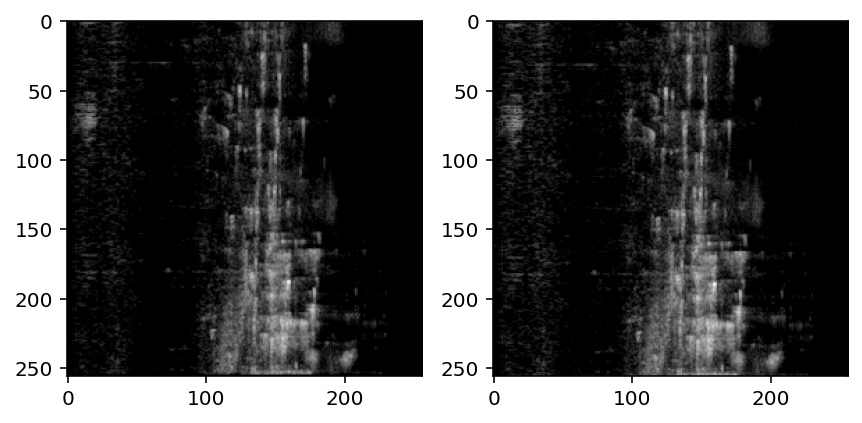

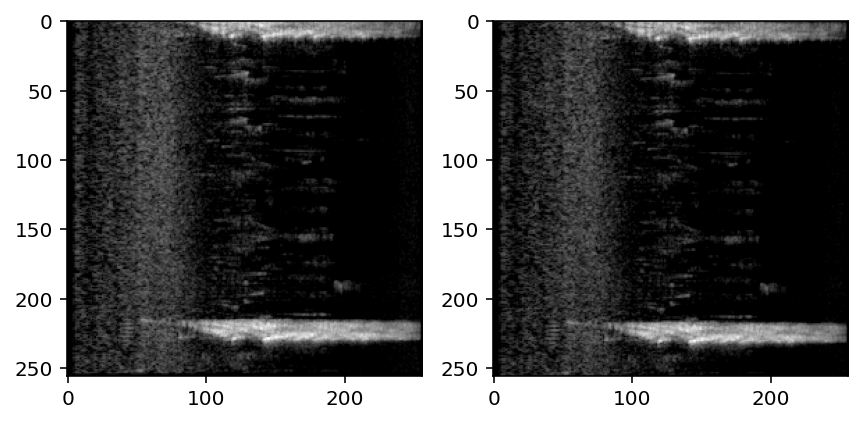

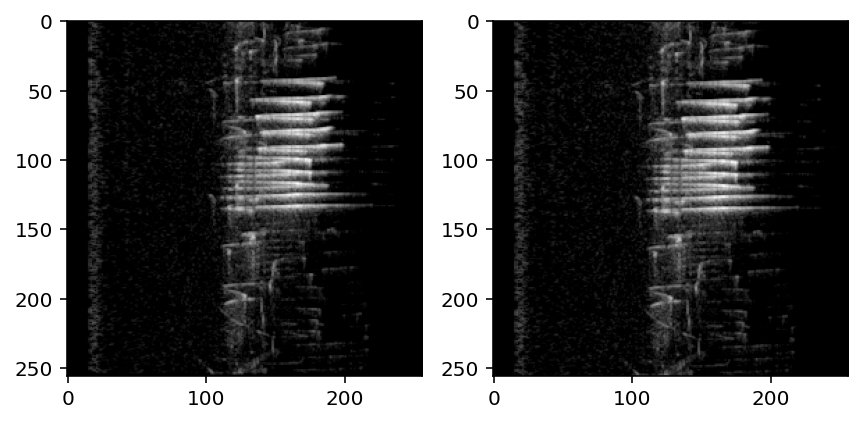

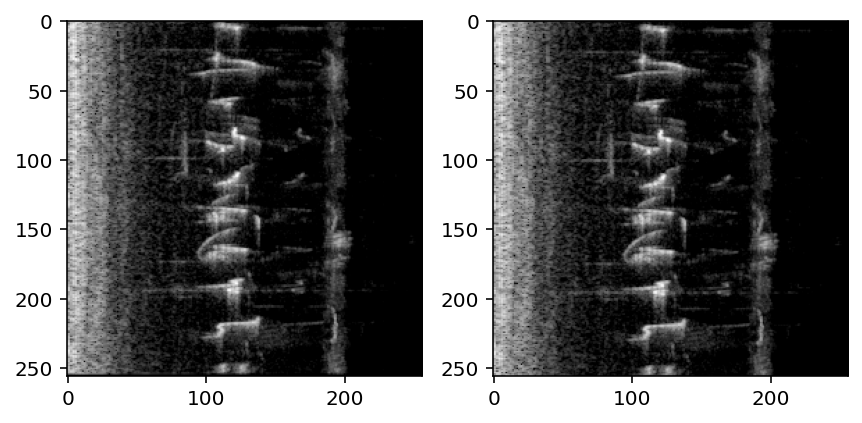

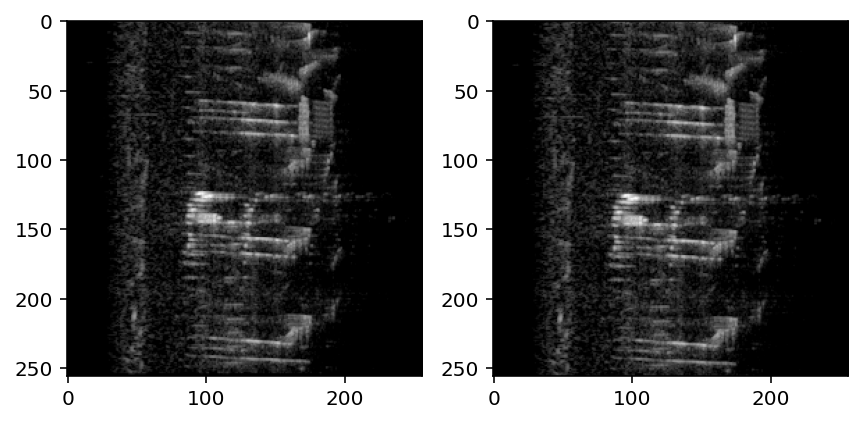

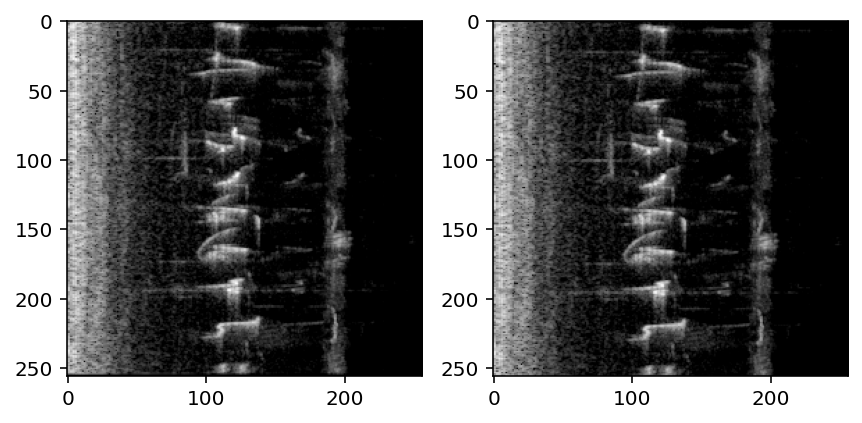

In [11]:
for i in range(len(msgs_f[:10])):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.5))
    a = msgs_rgb[i]
    b = float2d_to_rgb(msg_p.msg(waves[i], N_MELS, N_TIMESTEPS, POWER).T)
    ax1.imshow(a)
    ax2.imshow(b)
    fig.show()